# Dense Overlap Score Demo
This notebook explains step by step how the dense overlap score is computed for a given pair of images.

### Setup

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os
import numpy as np
import pycolmap
import matplotlib.pyplot as plt
from matplotlib.image import imread

from megadepth.utils.projections import backward_project, forward_project
from megadepth.utils.utils import camera_pixel_grid
from megadepth.utils.read_write_dense import read_array

In [29]:
def plot_images(images: list, titles: list) -> None:
    fig = plt.figure(figsize=(30, 30))

    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1)
        plt.axis("off")
        plt.imshow(images[i])
        plt.title(titles[i])
 
    plt.show()


def single_scatter_plot(x, y, c, title=""):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plt.gca().invert_yaxis()
    ax.scatter(x, y, c=c, s=1)
    plt.title(title)
    plt.show()


def multiple_scatter_plots(x: list, y: list, c: list, titles: list):
    n = len(x)
    fig, axes = plt.subplots(1, n, figsize=(8 * n, 6))
    for i in range(n):
        axes[i].invert_yaxis()
        axes[i].scatter(x[i], y[i], c=c[i], s=1)
        axes[i].title.set_text(titles[i])        
    plt.show()

Feel free to change the variables in the following cell to try out different things:

In [30]:
# path to the directory that contains the following subdirectories of the dense reconstruction: 
# "image", "sparse", "stereo/depth_maps"
dense_model_dir = os.path.join("..", "data", "south-building", "dense", "colmap")

# image IDs
id_1 = 26
id_2 = 28

# by which factor to downsample the depth maps for the computation of the score
downsample = 10

# Dense points with an absolute relative depth error below this threshold are considered as inliers
rel_thresh = 0.03

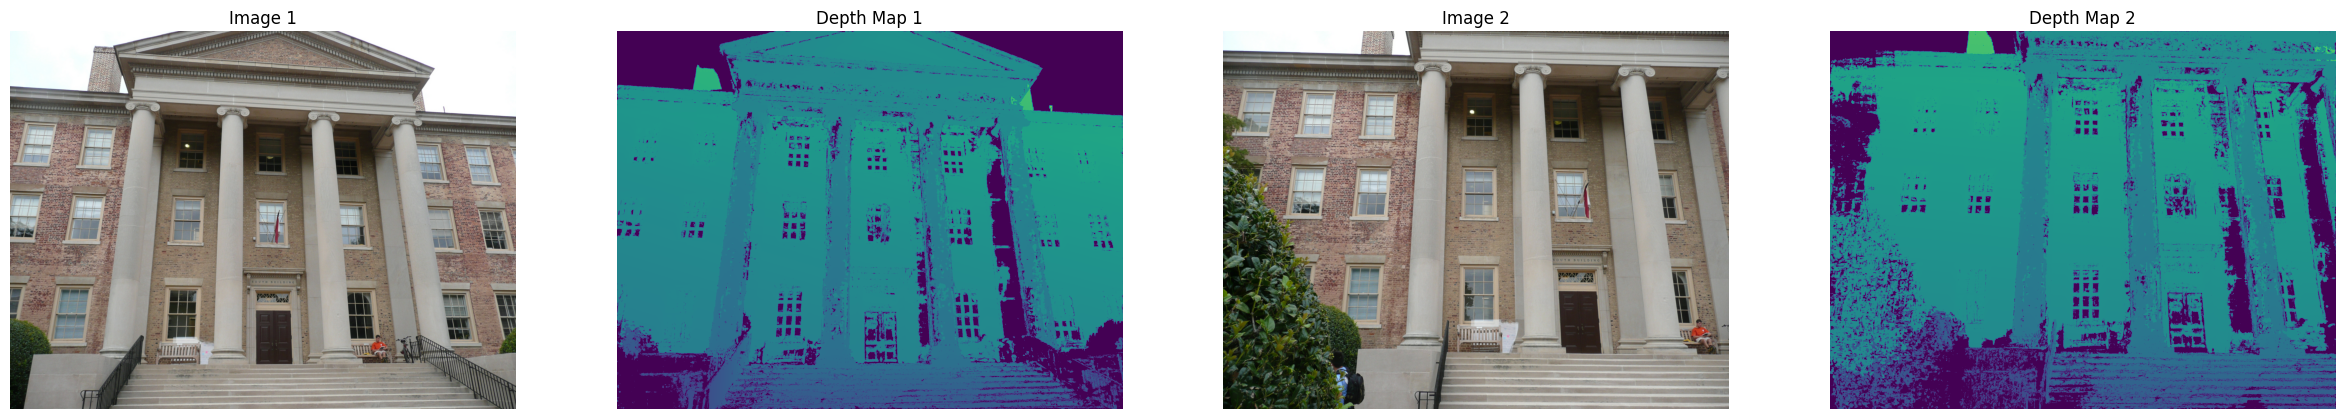

In [31]:
# load images, cameras and depth maps
image_dir = os.path.join(dense_model_dir, "images")
depth_map_dir = os.path.join(dense_model_dir, "stereo", "depth_maps")

reconstruction = pycolmap.Reconstruction(os.path.join(dense_model_dir, "sparse"))
images = reconstruction.images
cameras = reconstruction.cameras
point3D = reconstruction.points3D

image_1 = images[id_1]
image_2 = images[id_2]
camera_1 = cameras[image_1.camera_id]
camera_2 = cameras[image_2.camera_id]
depth_map_1 = read_array(os.path.join(depth_map_dir, f"{image_1.name}.geometric.bin"))
colors_1 = imread(os.path.join(image_dir, image_1.name))
depth_map_2 = read_array(os.path.join(depth_map_dir, f"{image_2.name}.geometric.bin"))
colors_2 = imread(os.path.join(image_dir, image_2.name))

plot_images([colors_1, depth_map_1, colors_2, depth_map_2], ["Image 1", "Depth Map 1", "Image 2", "Depth Map 2"])

### Downsampling
As a first step, we downsample the depth map. This speeds up the computation and is a fairly accurate estimation of the actual dense overlap score. We then filter out all invalid depth values.

In [32]:
# gather depth values that we want to check in a vector
depth_1 = depth_map_1[::downsample, ::downsample].ravel()

# get the corresponding 2D coordinates in image 1
points_2d = camera_pixel_grid(camera_1, downsample)

# filter out invalid depth values
valid_depth_mask = depth_1 > 0.0
depth_1 = depth_1[valid_depth_mask]
points_2d = points_2d[valid_depth_mask]

# number of dense features we are considering for the score computation
n_features = depth_1.size

print(f"{n_features} dense features in image 1 will be considered for the overlap score")

34069 dense features in image 1 will be considered for the overlap score


We consider the following subsampled pixels for the computation of the dense overlap score:


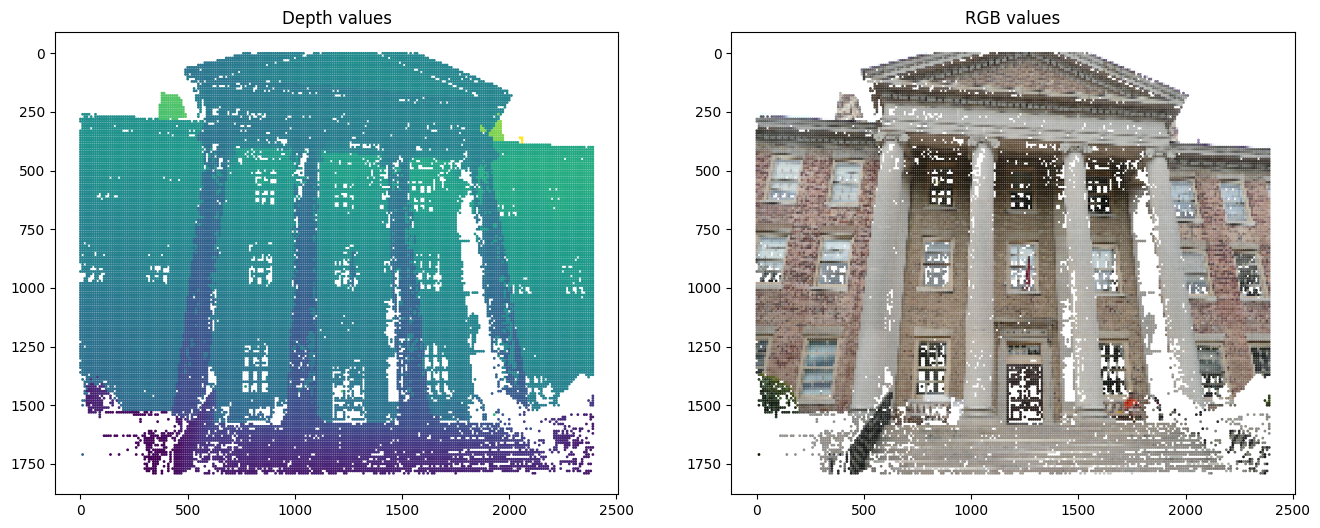

In [33]:
print("We consider the following subsampled pixels for the computation of the dense overlap score:")

# Note: the color values are stored column-wise and not row-wise!
rgb = np.array([colors_1[int(coords[1]), int(coords[0])] for coords in points_2d]) / 255

multiple_scatter_plots(
    x=2*[points_2d[:, 0]],
    y=2*[points_2d[:, 1]],
    c=[depth_1, rgb],
    titles=["Depth values", "RGB values"],
)

### Backprojection
Next, we backproject all dense features from image 1 to 3D using the corresponding (valid) depth values in the first depth map.

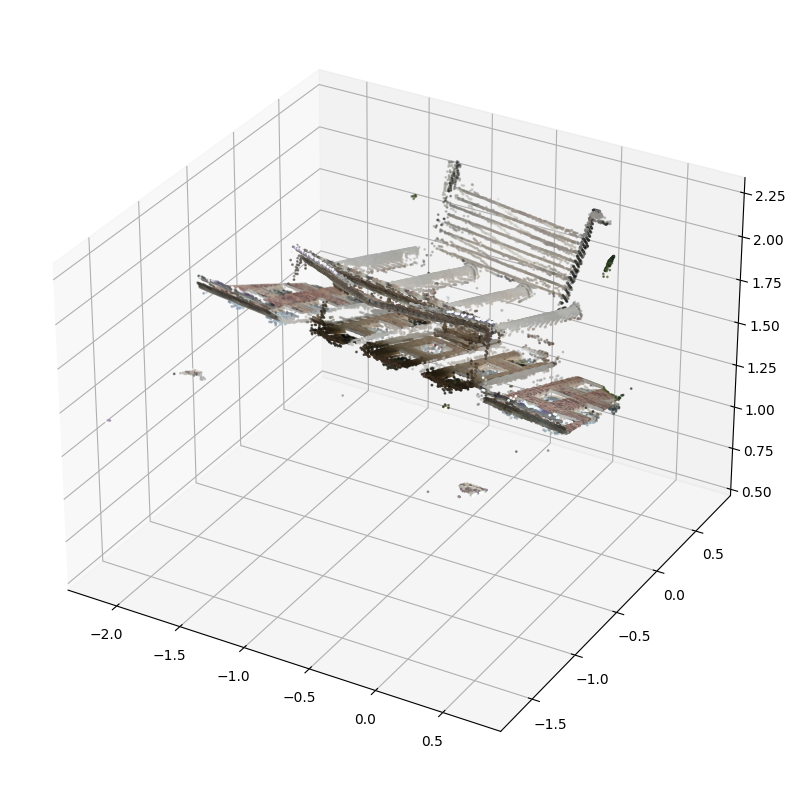

In [45]:
# backproject all valid 2D points from image 1 to 3D
points_3d = backward_project(
    points_2d=points_2d,
    image=image_1,
    camera=camera_1,
    depth=depth_1,
)

print("Dense features from image 1 in 3D:")
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=1, c=rgb)
plt.show()

### Forward Projection
Then, we project all backprojected 3D points from image 1 to the image space of image 2. All invalid points, i.e. points that lie outside of image 2, are discarded. We calculate the absolute relative depth error between the depth values obtained through the 3D-2D projection and the corresponding depth values in the second depth map.

These are the dense features from image 1 that are successfully projected to image 2:


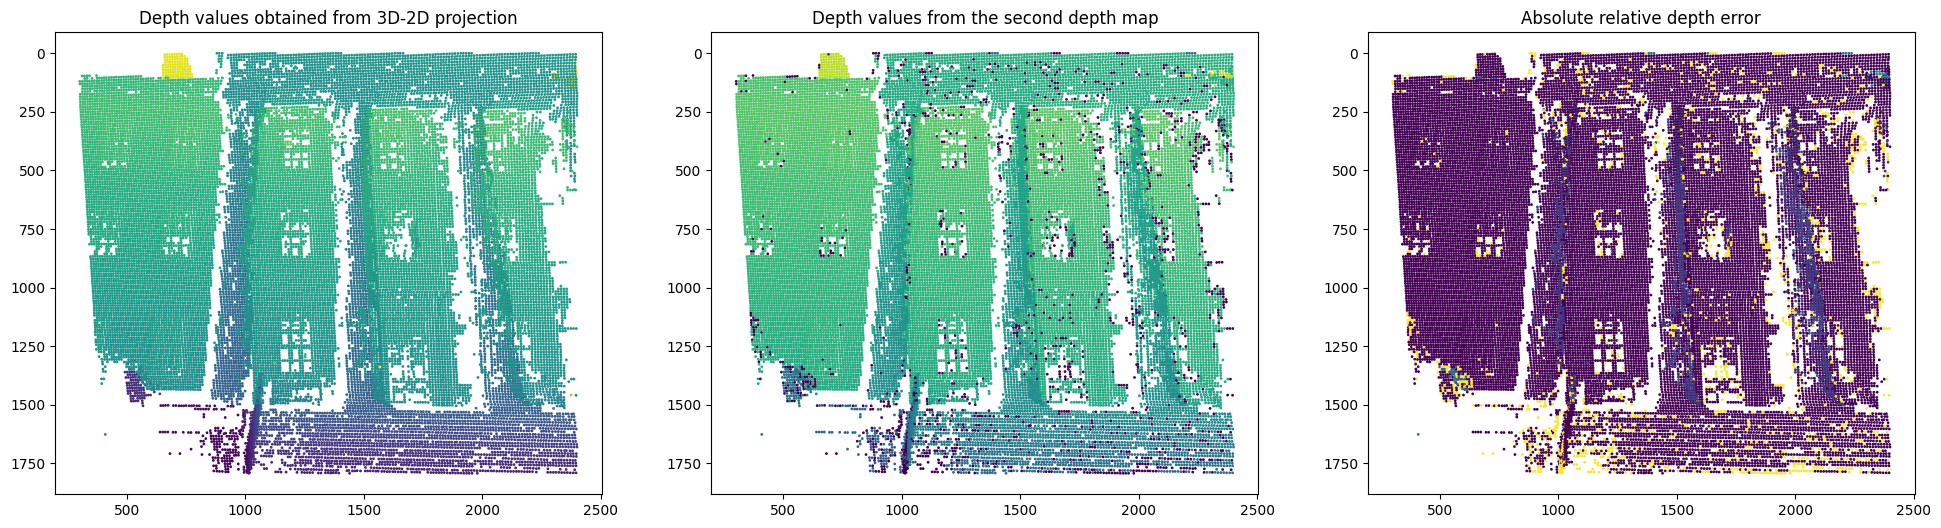

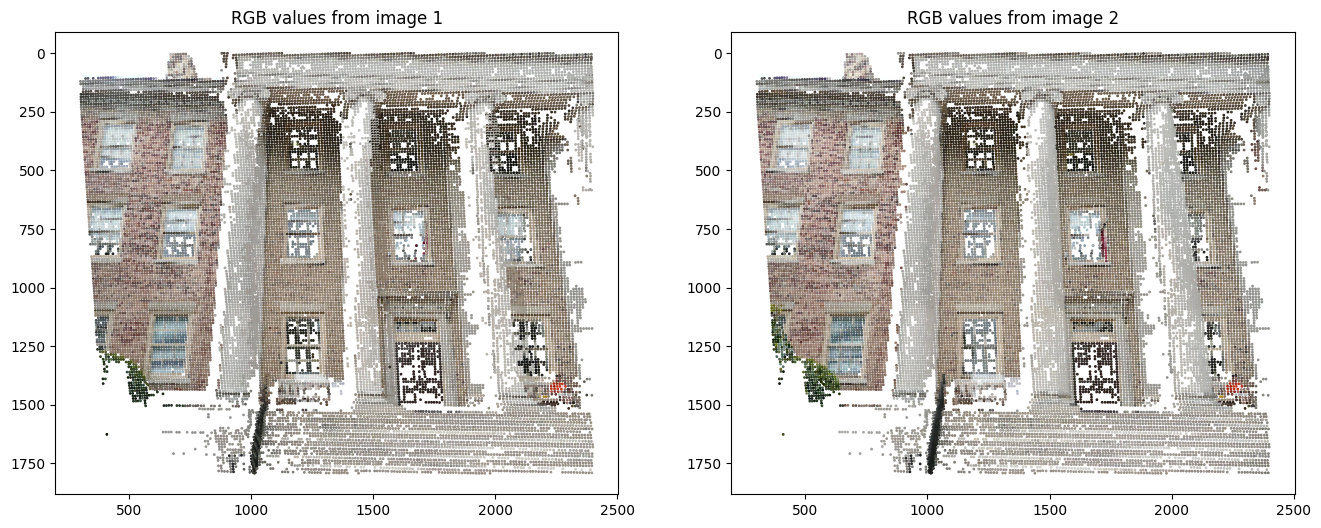

In [36]:
# project all 3D points to image 2 to obtain 2D points and associated depth values
proj_points_2d, proj_depths, proj_mask = forward_project(
    points_3d=points_3d, image=image_2, camera=camera_2, return_depth=True, return_mask=True
)

# get corresponding depth values from the second depth map
depth_2 = np.array(
    # Note: the depth map values are stored column-wise and not row-wise!
    [depth_map_2[coords[1] - 1, coords[0] - 1] for coords in proj_points_2d] 
)

# compute absolute relative depth errors
abs_rel_error = np.abs(depth_2 / proj_depths - 1.0)

print("These are the dense features from image 1 that are successfully projected to image 2:")

multiple_scatter_plots(
    x=3*[proj_points_2d[:, 0]],
    y=3*[proj_points_2d[:, 1]],
    c=[proj_depths, depth_2, abs_rel_error],
    titles=[
        "Depth values obtained from 3D-2D projection",
        "Depth values from the second depth map",
        "Absolute relative depth error",
    ],
)

# RGB values from image 1 and image 2
# Note: the depth map values are stored column-wise and not row-wise!
rgb_1 = np.array([colors_1[int(coords[1]), int(coords[0])] for coords in points_2d[proj_mask]]) / 255
rgb_2 = np.array([colors_2[int(coords[1])-1, int(coords[0])-1] for coords in proj_points_2d]) / 255

multiple_scatter_plots(
    x=2*[proj_points_2d[:, 0]],
    y=2*[proj_points_2d[:, 1]],
    c=[rgb_1, rgb_2],
    titles=[
        "RGB values from image 1",
        "RGB values from image 2",
    ],
)


Here is a histogram that shows the absolute relative depth errors between the asscociated depth values obtained through the projections from 3D to 2D and the actual depth values stored in the second depth map.

If a dense feature from image 1 lands on a pixel in image 2 that has an invalid depth value 0.0, the absolute error is 100% because: $$ abs({0.0 \over x} - 1.0) = 1.0 $$

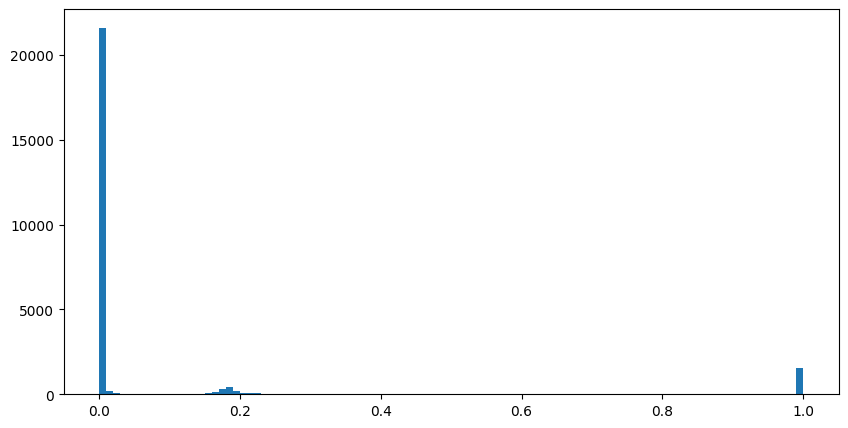

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(abs_rel_error, bins=100)
plt.show()

### Thresholding
Finally, we threshold the dense features that were successfully projected to image 2 based on the absolute relative depth error to obtain the final dense overlap score.

In [44]:
n_inliners = np.count_nonzero(abs_rel_error < rel_thresh)
score = n_inliners / n_features

print(f"{n_features} dense features in image 1 were considered for the overlap score")
print(f"{proj_points_2d.shape[0]} features were succesfully projected to image 2 (i.e. they lie inside image 2)")
print(f"{n_inliners} features have an acceptable absolute relative depth error (less than {rel_thresh * 100}%)")

print(f"\n==> dense overlap score: {score}")

34069 dense features in image 1 were considered for the overlap score
25031 features were succesfully projected to image 2 (i.e. they lie inside image 2)
21868 features have an acceptable absolute relative depth error (less than 3.0%)

==> dense overlap score: 0.6418738442572427
